In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading a test case with some data

First we define a collision checker function.

In [2]:
def is_collision_free(x,y):
    columns = []
    columns.append(((-math.pi/2 - 0.2, -math.pi/2 + 0.2),(-0.1,0.1)))
    columns.append(((-0.2, 0.2),(-1.1,-0.9)))
    columns.append(((math.pi/2 - 0.2, math.pi/2 + 0.2),(0.9,1.1)))
    if x <= -math.pi or x > math.pi or y <= -math.pi or y > math.pi:
        raise Exception("point needs to be in [-pi,pi] x [-pi,pi]")
    for column in columns:
        in_x_col = x >= column[0][0] and x <= column[0][1]
        in_y_op = y > column[1][0] and y < column[1][1]
        if in_x_col and not in_y_op:
            return False
    return True

Now we have a look at the configuration space that this collision checker defines:

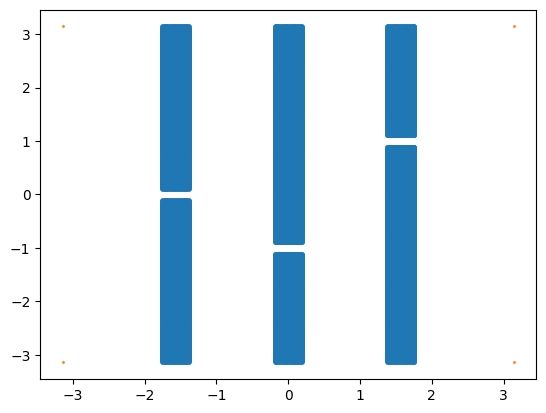

In [3]:
num_samples = 500

x_values = [ math.pi * (n/num_samples) - math.pi * (1-n/num_samples) for n in range(1,num_samples+1)]
y_values = x_values
value_grid = []
for y in y_values:
    y_section = [(x,y,is_collision_free(x,y)) for x in x_values]
    value_grid.append(y_section)

x_collisions = []
y_collisions = []
for y_row in value_grid:
    for entry in y_row:
        if not entry[2]:
            x_collisions.append(entry[0])
            y_collisions.append(entry[1])
plt.scatter(x_collisions, y_collisions, s =5)
plt.scatter([-3.1415,-3.1415, 3.1415,3.1415], [-3.1415,3.1415,-3.1415,3.1415], s = 1)

Now `value_grid` is a `500 x 500` list. It has one list for each of the 500 y-values. This list has 500 entries, one for each x-value and whether or not that point is in collision or not. Let's turn this into a `250000 x 3` tensor (250,000 data points, each with a x-value, a y-value, and a collision boolean).

In [4]:
train_data = torch.tensor([value_grid[i][j] for i in range(500) for j in range(500)])

In [5]:
train_data.shape

torch.Size([250000, 3])

In [6]:
train_data[0] # (x-coord, y-coord, collision-free (= 1))

tensor([-3.1290, -3.1290,  1.0000])

Want three models: One not considering the class of a point, one absorbing the class in the the euclidean distance, and one incorporating binary cross entropy for the class.

# Model 1
In this model, we are not considering the class of a point in the loss function at all, just the Euclidean distance between the original and reconstructed points.

 NEED TO ENSURE OUPUT IS IN $[0,2\pi]^{\texttt{input_dim}}$.

In [7]:
class VAE1(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device=device):
        super(VAE1, self).__init__()

        # encoder - THIS CAN BE MESSED AROUND WITH
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)
        
        # decoder - THIS CAN ALSO BE MESSED AROUND WITH
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim)
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

We need to modify the training data to not include whether the point is in collision or not (the third coordinate).

In [8]:
train_data1 = train_data[:, :2]

In [9]:
train_data1

tensor([[-3.1290, -3.1290],
        [-3.1165, -3.1290],
        [-3.1039, -3.1290],
        ...,
        [ 3.1165,  3.1416],
        [ 3.1290,  3.1416],
        [ 3.1416,  3.1416]])

We just set up a model with $2$-dimensional input, $2$-dimensional hidden layer, and latent dimension $1$. The output of the model is the decoded point, the mean, and the log_var.

In [10]:
model1 = VAE1(2,2,1)
model1(train_data1[0])

(tensor([-0.6441, -0.5202], grad_fn=<ViewBackward0>),
 tensor([0.5086], grad_fn=<ViewBackward0>),
 tensor([-0.0140], grad_fn=<ViewBackward0>))

Next we define the loss function. Here, the loss function is simple: just the Euclidean distance between the encoded and the unencoded point (and the KL divergence). We could also add weight parameters to control how much the KL divergence contributes versus the Euclidean distance.

In [11]:
def loss_function1(x, x_hat, mean, log_var, alpha = 1): # alpha controls weight of KL-Div loss.
    
    # Euclidean reconstruction loss
    dist = torch.sqrt(torch.sum((x_hat - x)**2)) # Euclidean distance
    reconstruction_loss = dist
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    #return reconstruction_loss + KLD
    return reconstruction_loss + alpha*KLD

### Training model 1

In [12]:
losses = []

In [23]:
model = model1
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-5)
epochs = 50
batch_size = 1000 # for minibatches
    
model.train()

for epoch in range(epochs):
    print(epoch, end=' ')
    # build a data loader for this epoch
    loader = DataLoader(dataset = train_data1, batch_size = batch_size, shuffle = True)
    
    # loop over the batches from the loader
    for batch in loader:
        batch = batch.to(device)
        # reset optimizer's gradients
        optimizer.zero_grad()
        # run the model on all inputs
        preds = model(batch)
        # rename the different parts of the prediction
        x_hats, means, log_vars = preds[0], preds[1], preds[2]
        # compute the loss function on the predictions
        loss = loss_function1(batch, x_hats, means, log_vars, alpha = 0.01)
        losses.append(loss.item())
        # compute the gradient of the loss function
        loss.backward()
        # update the parameters based on the gradient
        optimizer.step()
    # Uncomment this to check in on the progress each epoch
    #epoch_preds = model(train_data1)
    #epoch_x_hats, epoch_means, epoch_log_vars = epoch_preds[0], epoch_preds[1], epoch_preds[2]
    #print('Epoch: ' + str(epoch) + '\t Loss: ' + str(loss_function1(train_data1, epoch_x_hats, epoch_means, epoch_log_vars)))
    #losses.append(loss_function1(train_data1, epoch_x_hats, epoch_means, epoch_log_vars).item())

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

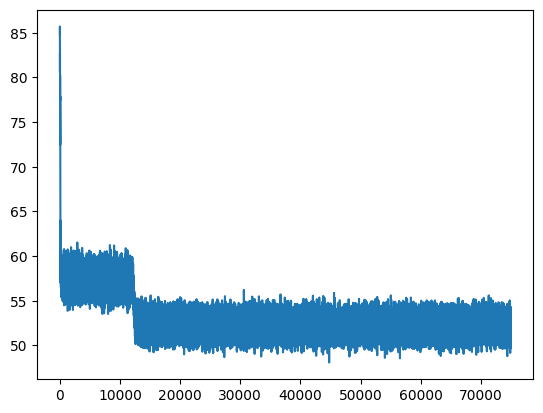

In [24]:
plt.plot(losses)

Let's look at how the model encodes the training data. We'll just plot the means of the embeddings.

In [64]:
embeds = model.encode(train_data1)
embed_means = embeds[0].detach().view(250000)
embed_log_vars = embeds[1].detach().view(250000)
embed_means, embed_log_vars

(tensor([ 0.1235,  0.1234,  0.1234,  ..., -0.3561, -0.3570, -0.3580]),
 tensor([7.2107e-05, 7.2113e-05, 7.2119e-05,  ..., 1.2102e-04, 1.2112e-04,
         1.2121e-04]))

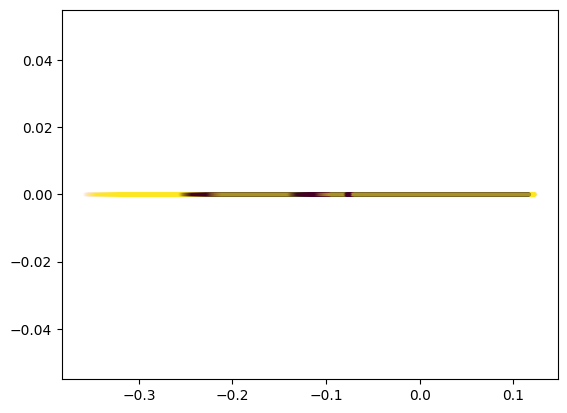

In [62]:
plt.scatter(embed_means, torch.zeros_like(embed_means), c = train_data[:,2], alpha = 0.01, s = 5)

Doesn't look like good separation between collision points and non-collision points like we would have hoped.

Just to remind ourselves, let's look at the configuration space.

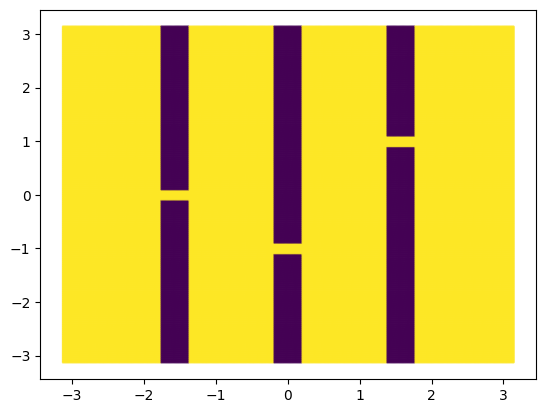

In [57]:
plt.scatter(train_data[:,0], train_data[:,1], c = train_data[:,2], s = 0.1)

Now let's check how the decodings of the means look in the ambient space.

In [58]:
decodes = model.decode(embeds[0]).detach()
decodes

tensor([[-2.5722, -2.9344],
        [-2.5713, -2.9342],
        [-2.5703, -2.9340],
        ...,
        [ 4.2914,  2.5516],
        [ 4.3057,  2.5544],
        [ 4.3199,  2.5573]])

This looks peculiar...not sure what is going on.

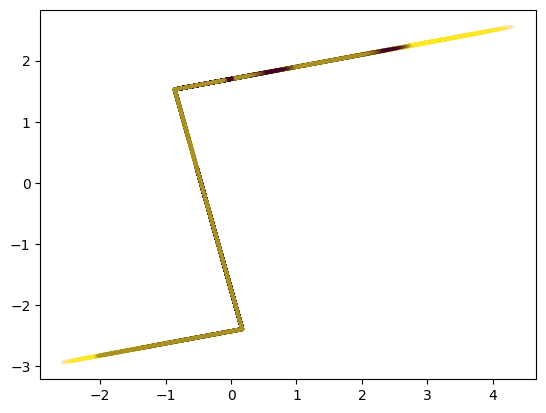

In [63]:
plt.scatter(decodes[:,0], decodes[:,1], c = train_data[:,2], alpha = 0.01, s = 5)

# Model 2
Absorbing the class loss into the Euclidean norm

In [65]:
class VAE2(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device=device):
        super(VAE2, self).__init__()

        # encoder - THIS CAN BE MESSED AROUND WITH
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)
        
        # decoder - THIS CAN ALSO BE MESSED AROUND WITH
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim)
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        x_hat[-1] = torch.sigmoid(x_hat[-1]) # now we want to make sure the third coordinate is between 0 and 1.
        return x_hat, mean, logvar

In [66]:
model2 = VAE2(3,2,1)

In [67]:
model2(train_data[20])

(tensor([0.2049, 0.4366, 0.3189], grad_fn=<AsStridedBackward0>),
 tensor([-0.0004], grad_fn=<ViewBackward0>),
 tensor([0.3910], grad_fn=<ViewBackward0>))

The code for the loss function is actually identical to before.

In [68]:
def loss_function2(x, x_hat, mean, log_var, alpha = 1):
    
    # Euclidean reconstruction loss
    dist = torch.sqrt(torch.sum((x_hat - x)**2)) # Euclidean distance
    reconstruction_loss = dist
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    #return reconstruction_loss + KLD
    return reconstruction_loss + alpha*KLD

### Training model 2

In [69]:
losses = []

In [74]:
model = model2
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-1)
epochs = 50
batch_size = 1000 # for minibatches
    
model.train()

for epoch in range(epochs):
    print(epoch, end=' ')
    # build a data loader for this epoch
    loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
    
    # loop over the batches from the loader
    for batch in loader:
        batch = batch.to(device)
        # reset optimizer's gradients
        optimizer.zero_grad()
        # run the model on all inputs
        preds = model(batch)
        # rename the different parts of the prediction
        x_hats, means, log_vars = preds[0], preds[1], preds[2]
        # compute the loss function on the predictions
        loss = loss_function2(batch, x_hats, means, log_vars, alpha = 0.01)
        losses.append(loss.item())
        # compute the gradient of the loss function
        loss.backward()
        # update the parameters based on the gradient
        optimizer.step()
    # Uncomment this to check in on the progress each epoch
    #epoch_preds = model(train_data1)
    #epoch_x_hats, epoch_means, epoch_log_vars = epoch_preds[0], epoch_preds[1], epoch_preds[2]
    #print('Epoch: ' + str(epoch) + '\t Loss: ' + str(loss_function1(train_data1, epoch_x_hats, epoch_means, epoch_log_vars)))
    #losses.append(loss_function1(train_data1, epoch_x_hats, epoch_means, epoch_log_vars).item())

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

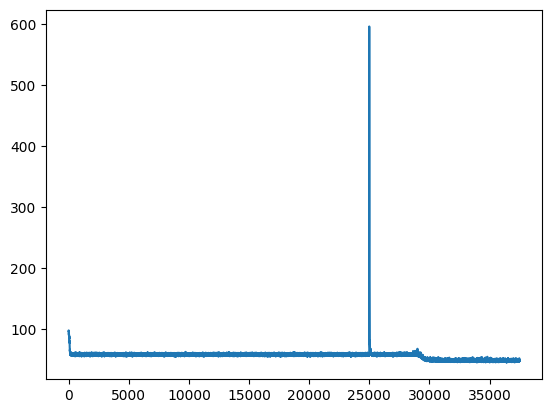

In [75]:
plt.plot(losses)

Let's look at how the model encodes the training data. We'll just plot the means of the embeddings.

In [77]:
embeds = model.encode(train_data)
embed_means = embeds[0].detach().view(250000)
embed_log_vars = embeds[1].detach().view(250000)
embed_means, embed_log_vars

(tensor([-0.3772, -0.3767, -0.3761,  ...,  0.0791,  0.0796,  0.0802]),
 tensor([-0.0170, -0.0170, -0.0170,  ..., -0.0112, -0.0112, -0.0112]))

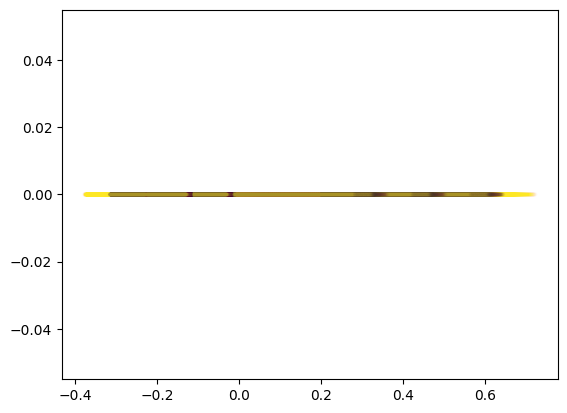

In [78]:
plt.scatter(embed_means, torch.zeros_like(embed_means), c = train_data[:,2], alpha = 0.01, s = 5)

Doesn't look like good separation between collision points and non-collision points like we would have hoped.

Now let's check how the decodings of the means look in the ambient space.

In [79]:
decodes = model.decode(embeds[0]).detach()
decodes

tensor([[-2.5653, -2.7470,  0.7678],
        [-2.5637, -2.7459,  0.7678],
        [-2.5620, -2.7448,  0.7678],
        ...,
        [ 1.4673,  0.8545,  0.8082],
        [ 1.4631,  0.8569,  0.8082],
        [ 1.4589,  0.8593,  0.8082]])

Still weird looking...also I'm not sure why the colorbar looks al

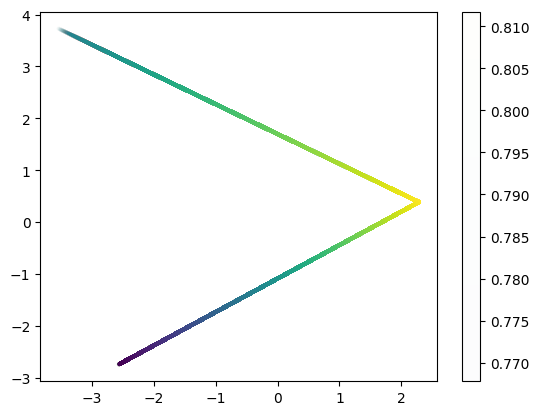

In [86]:
plt.scatter(decodes[:,0], decodes[:,1], c = decodes[:,2], alpha = 0.01, s = 5)
plt.colorbar()

NEXT PART IS INCOMPLETE!

# Model 3
A separate binary cross entropy loss part for the class

In [ ]:
class VAE3(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device=device):
        super(VAE3, self).__init__()

        # encoder - THIS CAN BE MESSED AROUND WITH
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)
        
        # decoder - THIS CAN ALSO BE MESSED AROUND WITH
        self.point_decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim)
            nn.Sigmoid()
            )
        
        # CLASS decoder - THIS CAN ALSO BE MESSED AROUND WITH. This is to decode (predict) whether the pt is in collision or not.
        self.label_decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1), # just decoding 1 thing here: collision or not
            nn.Sigmoid() # make the prediction a probability
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    #def decode(self, x):
    #    return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        #x_hat = self.decode(z)
        x_hat = self.point_decoder(z)
        x_hat[2] = sigmoid(x_hat[2])
        x_hat[0] = (sigmoid(x_hat[0]) - 0.5)*2*math.pi
        x_hat[1] = (sigmoid(x_hat[1]) - 0.5)*2*math.pi
        #label_hat = self.label_decoder(z)
        return x_hat, mean, logvar

In [ ]:
def loss_function3(x, x_hat, mean, log_var, alpha = 1, beta = 1):
    # alpha and beta are parameters to determine how much to weight Euclidean distance and correct classification
    
    for i in range(len(x_hat)):
        if i < len(x_hat) - 1:
            if x_hat[i] > math.pi or x_hat[i] <= -math.pi:
                return 1e6
        else:
            if x_hat[i] < 0 or x_hat[i] > 1:
                return 1e6
    
    # Euclidean reconstruction loss
    dist = torch.sqrt(torch.sum((x_hat - x)**2)) # Euclidean distance
    reconstruction_loss = alpha*dist
    
    # BCE label loss
    #label = is_collision_free(x) # or label(x)
    #pred = COLLISIONCHECKER(x_hat)
    
    # need probabilities that it is collision and not collision. So we need a collision predictor
    # IDEA: make the COLLISIONCHECKER function a neural network classifier so that we can backprop.
    
    #label_loss = beta*nn.functional.binary_cross_entropy(label, label_hat, reduction='sum')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    #return reconstruction_loss + label_loss + KLD
    return torch.tensor(reconstruction_loss + KLD)

In [ ]:
m = torch.tensor(2)*torch.pi*(nn.Sigmoid() - torch.tensor(0.5))

In [ ]:
m(torch.tensor(3))

In [ ]:
torch.pi